# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #reduce overfitting
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "drive/MyDrive/SpringBoard/Sample Projects/Image Classification/dogs-vs-cats"

/content/drive/MyDrive/SpringBoard/Sample Projects/Image Classification/dogs-vs-cats


Loading train data

In [4]:
filenames = os.listdir('train')
categories = []

for filename in filenames:
  category = filename.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({'filename':filenames, 'category':categories})

In [5]:
df.head()

,filename,category
0,dog.9099.jpg,1
1,dog.91.jpg,1
2,dog.910.jpg,1
3,dog.9100.jpg,1
4,dog.9101.jpg,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   category  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


1    12500
0    12500
Name: category, dtype: int64


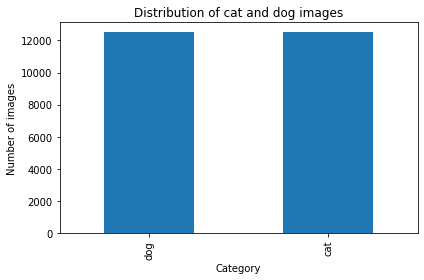

In [7]:
# Seems like a very uniform number of dogs and cats
print(df.category.value_counts())
df.category.value_counts().plot.bar()
plt.xticks(ticks=[0,1], labels=['dog','cat'])
plt.title('Distribution of cat and dog images')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.tight_layout()
plt.show()

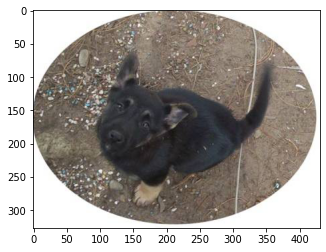

In [8]:
# Select a random image from dataset
sample = random.choice(filenames)
image = load_img('train/'+sample)
plt.imshow(image)

# Data prepation

In [9]:
df["category"] = df["category"].replace({1:'dog', 0:'cat'}) 

df_train, df_validation = train_test_split(df, test_size=0.2, random_state=1)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)

In [10]:
# Train set
df_train.category.value_counts()

cat    10021
dog     9979
Name: category, dtype: int64

In [11]:
# Validation set
df_validation.category.value_counts()

dog    2521
cat    2479
Name: category, dtype: int64

In [12]:
# Defining Image Definition
image_height, image_width = 150, 150
image_size = (image_width, image_height)
image_channels = 3

In [13]:
# Augmenting Image
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1.0/255., shear_range=0.1, zoom_range=0.2, horizontal_flip=True)
# training images in batches of 20
train_generator = train_datagen.flow_from_dataframe(df_train, directory='train/', x_col='filename', y_col='category', target_size=image_size, class_mode='binary', batch_size=20)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
# Augmenting Image
validation_datagen = ImageDataGenerator(rotation_range=15, rescale=1/255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True)
# training images in batches of 20
validation_generator = validation_datagen.flow_from_dataframe(df_validation, directory='train', x_col='filename', y_col='category', target_size=image_size, class_mode='binary', batch_size=20)

Found 5000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


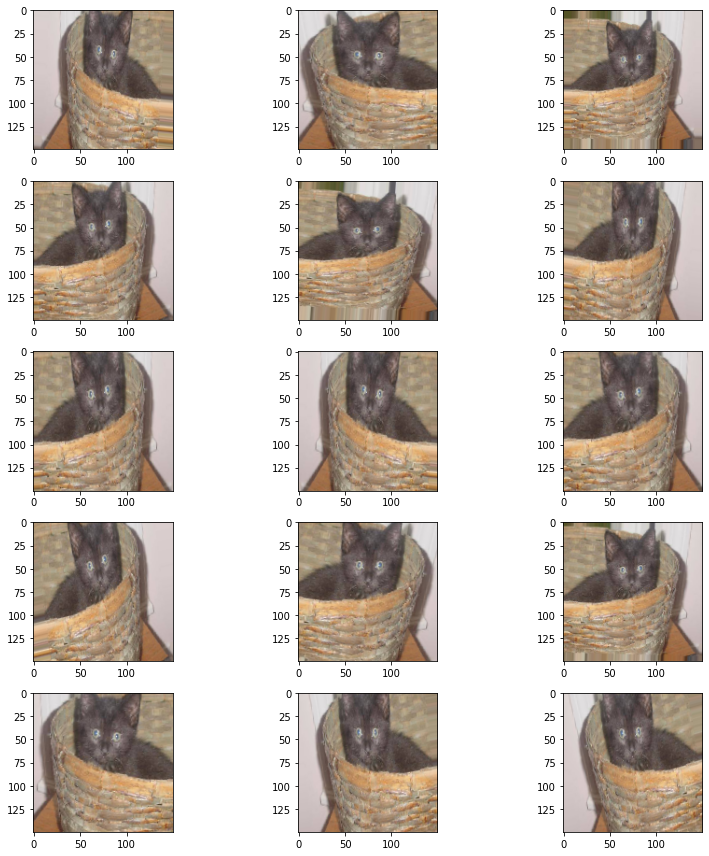

In [15]:
# Sampling a random augmeted image
aa = df_train.sample(n=1).reset_index(drop=True)
sample = train_datagen.flow_from_dataframe(aa, "train/", x_col='filename', y_col='category', target_size=image_size, class_mode='categorical')

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, y in sample:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Creating model

- Conv2D - a simple convolutional layer with 64 neuron
- MaxPooling2D - extracts the max values surrounding each target pixel as it moves from left to right and top to bottom
- Dense - connects previous layer to the next through neurons
- Flatten - flattens the layer after processing using Conv2D to fit Dense process

In [16]:
# Building Model
model = Sequential()

# Setting up layers of nodes
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

# Callbacks

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping to prevent overfitting
earlystopping = EarlyStopping(monitor='val_loss', patience=4)

# Reduce Learning Rate to increase efficiency by reducing learning rate when accuracy reaches a plateau
reducelr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlystopping, reducelr]

# Fit Model

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=25, callbacks=callbacks)

Epoch 1/25
1000/1000 [==============================] - 11711s 12s/step - loss: 0.7944 - accuracy: 0.6198 - val_loss: 0.6331 - val_accuracy: 0.6382
Epoch 2/25
1000/1000 [==============================] - 930s 929ms/step - loss: 0.5314 - accuracy: 0.7361 - val_loss: 0.5270 - val_accuracy: 0.7382
Epoch 3/25
1000/1000 [==============================] - 925s 925ms/step - loss: 0.4752 - accuracy: 0.7731 - val_loss: 0.5343 - val_accuracy: 0.7392
Epoch 4/25
1000/1000 [==============================] - 929s 929ms/step - loss: 0.4169 - accuracy: 0.8074 - val_loss: 0.5270 - val_accuracy: 0.7504
Epoch 5/25
1000/1000 [==============================] - 926s 926ms/step - loss: 0.3932 - accuracy: 0.8247 - val_loss: 0.5756 - val_accuracy: 0.7516
Epoch 6/25
1000/1000 [==============================] - 931s 931ms/step - loss: 0.3813 - accuracy: 0.8269 - val_loss: 0.4156 - val_accuracy: 0.8112
Epoch 7/25
1000/1000 [==============================] - 935s 935ms/step - loss: 0.3570 - accuracy: 0.8404 - val_

In [22]:
from keras.models import load_model

#model.save('model.h5')
history = load_model('model.h5')

In [ ]:
pd.DataFrame(model.history.history)

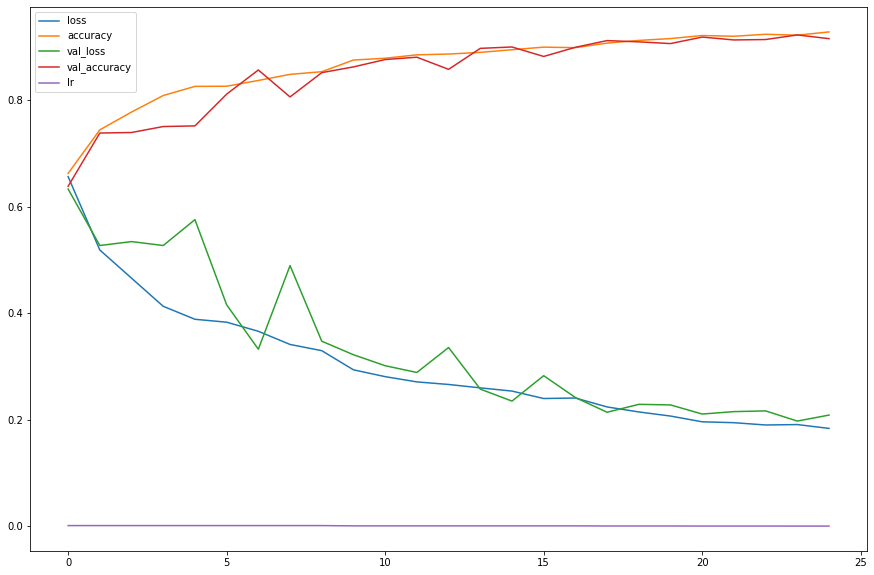

In [ ]:
pd.DataFrame(model.history.history).plot(figsize=(15,10))

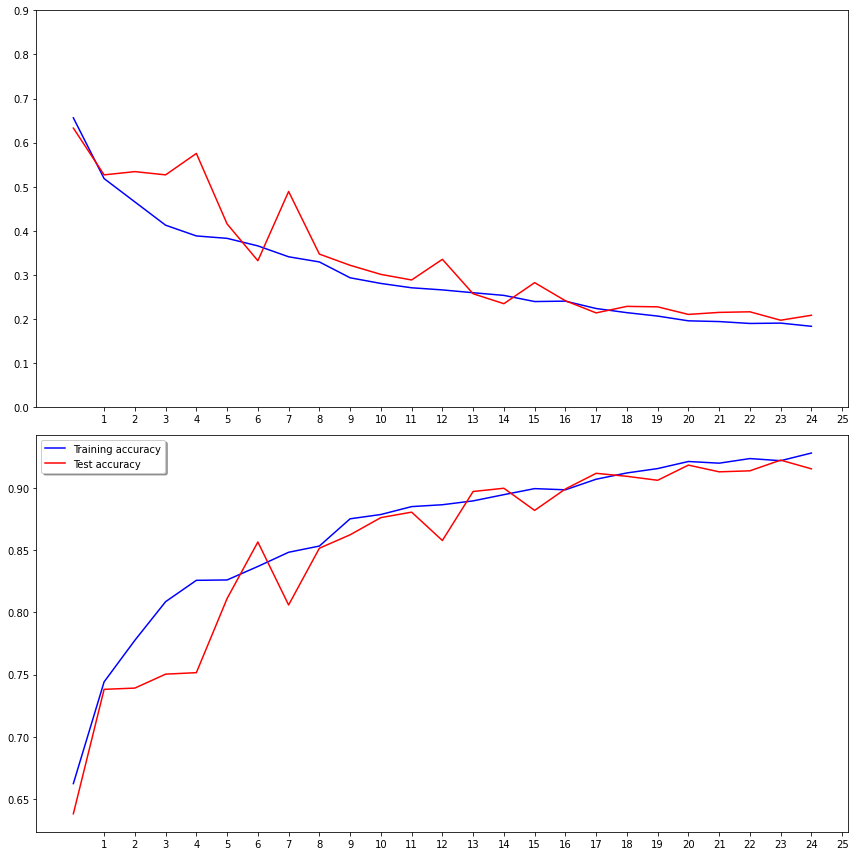

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Test loss")
ax1.set_xticks(np.arange(1, 26, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Test accuracy")
ax2.set_xticks(np.arange(1, 26, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [23]:
test_filenames = os.listdir("test")
df_validation = pd.DataFrame({'filename': test_filenames})
sample = df_validation.shape[0]

In [24]:
validation_generator = validation_datagen.flow_from_dataframe(df_validation, 'test/', x_col='filename', y_col=None, class_mode=None, target_size=image_size, batch_size=20, shuffle=False)

Found 12500 validated image filenames.


# Prediction

In [25]:
predict = model.predict(validation_generator, steps=np.ceil(sample/20))
# select category with highest probability using numpy average max
df_validation['category'] = np.argmax(predict, axis=-1)
# Convert predict category into generator class
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_validation['category'] = df_validation['category'].replace(label_map)

In [26]:
df_validation['category'] = df_validation['category'].replace({'dog':1, 'cat':0})

## Prediction results

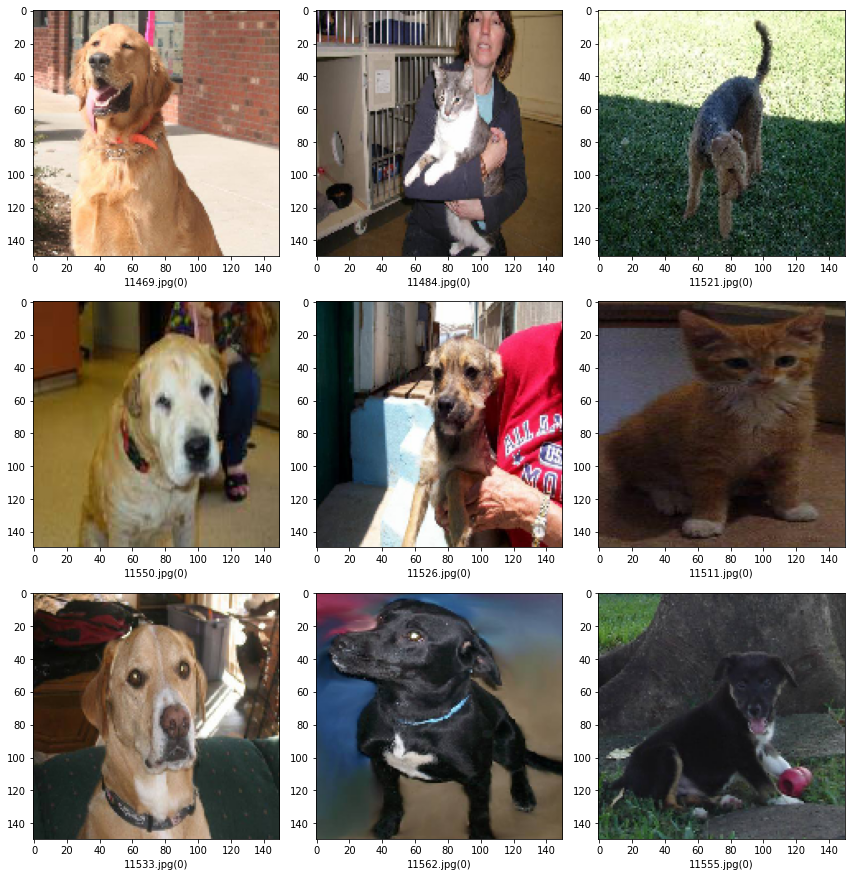

In [27]:
prediction = df_validation.head(9)
prediction.head()
plt.figure(figsize=(12, 24))
for index, row in prediction.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test/'+filename, target_size=image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + '{}'.format(category) + ')' )
plt.tight_layout()
plt.show()

## Prediction to CSV

In [ ]:
df_prediction = df_validation.copy()
df_prediction['id'] = df_prediction['filename'].str.split('.').str[0]
df_prediction['label'] = df_prediction['category']
df_prediction.drop(['filename', 'category'], axis=1, inplace=True)
df_prediction.to_csv('prediction.csv', index=False)